Original class distribution:
Label
0    120
1     39
Name: count, dtype: int64
Downsampled class distribution:
Label
0    39
1    39
Name: count, dtype: int64
Fitting 10 folds for each of 110 candidates, totalling 1100 fits
✅ Best Params: {'lr__C': 0.05994842503189409, 'lr__class_weight': None, 'lr__l1_ratio': 0.5}
📘 Classification Report (Train):
              precision    recall  f1-score   support

     Control       0.70      0.68      0.69        31
        ADHD       0.69      0.71      0.70        31

    accuracy                           0.69        62
   macro avg       0.69      0.69      0.69        62
weighted avg       0.69      0.69      0.69        62

ROC AUC (Train): 0.7065556711758584


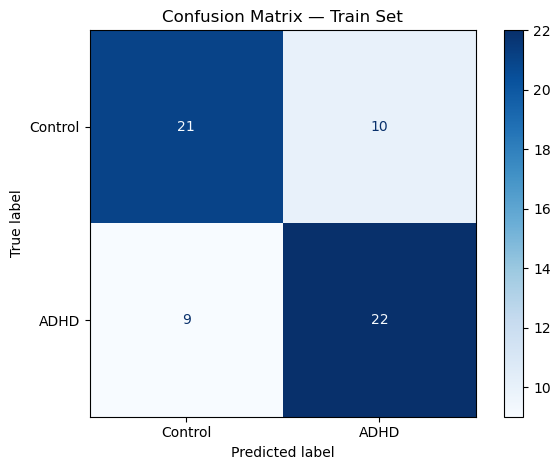

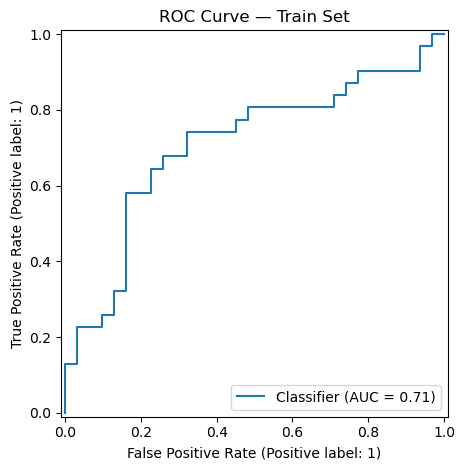

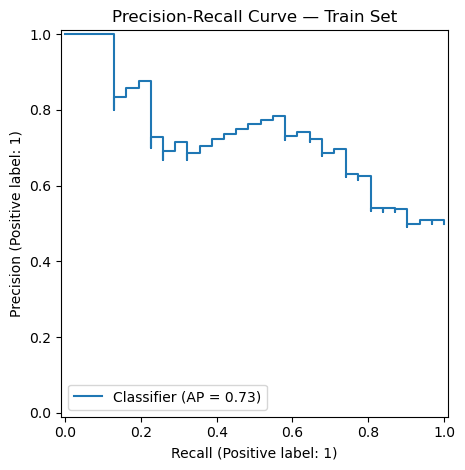


📊 Cross-Validated Scores:
fit_time: 0.2301
score_time: 0.0417
test_accuracy: 0.5500
train_accuracy: 0.6646
test_precision: 0.5429
train_precision: 0.6754
test_recall: 0.5583
train_recall: 0.6946
test_f1: 0.5114
train_f1: 0.6727
test_roc_auc: 0.5083
train_roc_auc: 0.7361

📘 Classification Report (Test):
              precision    recall  f1-score   support

     Control       0.50      0.62      0.56         8
        ADHD       0.50      0.38      0.43         8

    accuracy                           0.50        16
   macro avg       0.50      0.50      0.49        16
weighted avg       0.50      0.50      0.49        16

ROC AUC (Test): 0.609375


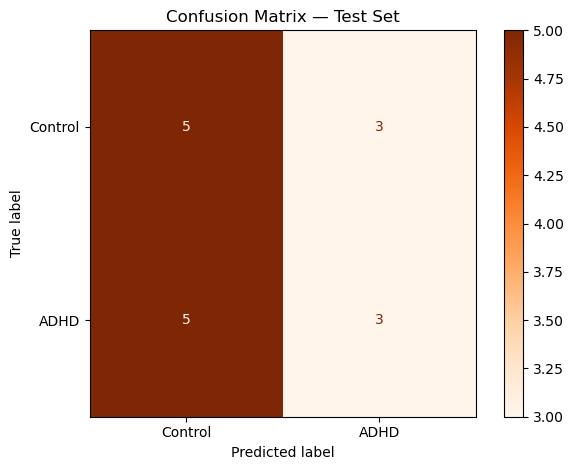

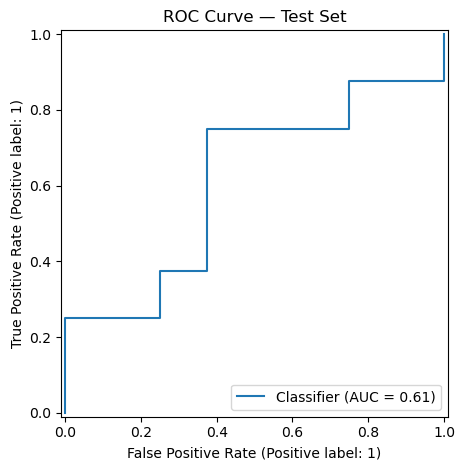

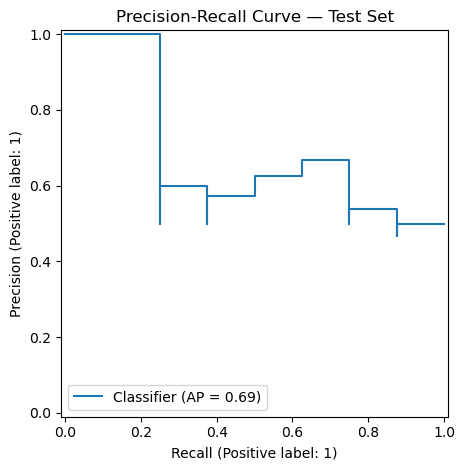

In [1]:
import numpy as np
import pandas as pd
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay)
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv('Combined_4Condition_Cleaned.csv')

# Define target and features
target_col = 'Label'
X = df.drop(columns=['Subject_ID', target_col])
y = df[target_col]

# Check class counts
print("Original class distribution:")
print(y.value_counts())

# Downsample majority class (0) to minority class size
df_majority = df[df[target_col] == 0]
df_minority = df[df[target_col] == 1]

n_minority = len(df_minority)
df_majority_downsampled = resample(
    df_majority,
    replace=False,
    n_samples=n_minority,
    random_state=42
)

df_downsampled = pd.concat([df_majority_downsampled, df_minority]).sample(frac=1, random_state=42).reset_index(drop=True)

X_down = df_downsampled.drop(columns=['Subject_ID', target_col])
y_down = df_downsampled[target_col]

print("Downsampled class distribution:")
print(y_down.value_counts())

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_down, y_down, test_size=0.2, stratify=y_down, random_state=42
)

# === Stratified K-Fold ===
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# === Feature Selector with Random Forest (on raw features) ===
rf_selector = SelectFromModel(
    estimator=RandomForestClassifier(n_estimators=100, random_state=42),
    threshold=-np.inf,
    max_features=4
)

# === ElasticNet Logistic Regression ===
elastic_model = LogisticRegression(
    penalty='elasticnet',
    solver='saga',
    max_iter=10000
)

# === Pipeline: Raw -> RF selector -> Scaler -> LogisticRegression ===
pipeline = Pipeline([
    ('feature_select', rf_selector),
    ('scaler', StandardScaler()),
    ('lr', elastic_model)
])

# === Param Grid ===
param_grid = {
    'lr__C': np.logspace(-3, 1, 10),
    'lr__l1_ratio': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
    'lr__class_weight': [None]
}

# === Grid SearchCV ===
grid_p = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring={
        'accuracy': 'accuracy',
        'precision': 'precision',
        'recall': 'recall',
        'f1': 'f1',
        'roc_auc': 'roc_auc'
    },
    refit='accuracy',
    cv=cv,
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

# === Fit Model ===
grid_p.fit(X_train, y_train)
print("✅ Best Params:", grid_p.best_params_)

# === Train Predictions ===
y_train_pred = grid_p.predict(X_train)
y_train_proba = grid_p.predict_proba(X_train)[:, 1]

# === Evaluation Metrics (Train) ===
print("📘 Classification Report (Train):")
print(classification_report(y_train, y_train_pred, target_names=['Control', 'ADHD']))
print("ROC AUC (Train):", roc_auc_score(y_train, y_train_proba))

# === Confusion Matrix (Train) ===
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, display_labels=['Control', 'ADHD'], cmap='Blues')
plt.title("Confusion Matrix — Train Set")
plt.tight_layout()
plt.show()

# === ROC Curve (Train) ===
RocCurveDisplay.from_predictions(y_train, y_train_proba)
plt.title("ROC Curve — Train Set")
plt.tight_layout()
plt.show()

# === Precision-Recall Curve (Train) ===
PrecisionRecallDisplay.from_predictions(y_train, y_train_proba)
plt.title("Precision-Recall Curve — Train Set")
plt.tight_layout()
plt.show()

# === Cross-Validated Scores ===
cv_scores = cross_validate(
    grid_p.best_estimator_,
    X_train, y_train,
    scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
    cv=cv,
    return_train_score=True
)

print("\n📊 Cross-Validated Scores:")
for k, v in cv_scores.items():
    print(f"{k}: {np.mean(v):.4f}")

# === TEST PREDICTIONS AND EVALUATION ===
y_test_pred = grid_p.predict(X_test)
y_test_proba = grid_p.predict_proba(X_test)[:, 1]

print("\n📘 Classification Report (Test):")
print(classification_report(y_test, y_test_pred, target_names=['Control', 'ADHD']))
print("ROC AUC (Test):", roc_auc_score(y_test, y_test_proba))

# === Confusion Matrix (Test) ===
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, display_labels=['Control', 'ADHD'], cmap='Oranges')
plt.title("Confusion Matrix — Test Set")
plt.tight_layout()
plt.show()

# === ROC Curve (Test) ===
RocCurveDisplay.from_predictions(y_test, y_test_proba)
plt.title("ROC Curve — Test Set")
plt.tight_layout()
plt.show()

# === Precision-Recall Curve (Test) ===
PrecisionRecallDisplay.from_predictions(y_test, y_test_proba)
plt.title("Precision-Recall Curve — Test Set")
plt.tight_layout()
plt.show()


In [2]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import numpy as np

n_repeats = 10
metrics = {'accuracy': [], 'f1_macro': [], 'roc_auc': []}

for i in range(n_repeats):
    print(f"Run {i+1}/{n_repeats}")
    # Downsample majority class with new random_state each time
    df_majority_downsampled = resample(
        df_majority,
        replace=False,
        n_samples=n_minority,
        random_state=42 + i
    )
    df_downsampled = pd.concat([df_majority_downsampled, df_minority]).sample(frac=1, random_state=42 + i).reset_index(drop=True)
    
    X_down = df_downsampled.drop(columns=['Subject_ID', target_col])
    y_down = df_downsampled[target_col]
    
    # Train/test split with stratify
    X_train, X_test, y_train, y_test = train_test_split(
        X_down, y_down, test_size=0.2, stratify=y_down, random_state=42 + i
    )
    
    # Fit model (you can reuse your pipeline and grid_p but fit fresh each time)
    grid_p.fit(X_train, y_train)
    
    # Predict on test
    y_test_pred = grid_p.predict(X_test)
    y_test_proba = grid_p.predict_proba(X_test)[:, 1]
    
    # Collect metrics
    metrics['accuracy'].append(accuracy_score(y_test, y_test_pred))
    metrics['f1_macro'].append(f1_score(y_test, y_test_pred, average='macro'))
    metrics['roc_auc'].append(roc_auc_score(y_test, y_test_proba))

# After all runs
for metric_name, scores in metrics.items():
    print(f"{metric_name}: Mean={np.mean(scores):.4f}, Std={np.std(scores):.4f}")


Run 1/10
Fitting 10 folds for each of 110 candidates, totalling 1100 fits
Run 2/10
Fitting 10 folds for each of 110 candidates, totalling 1100 fits
Run 3/10
Fitting 10 folds for each of 110 candidates, totalling 1100 fits
Run 4/10
Fitting 10 folds for each of 110 candidates, totalling 1100 fits
Run 5/10
Fitting 10 folds for each of 110 candidates, totalling 1100 fits
Run 6/10
Fitting 10 folds for each of 110 candidates, totalling 1100 fits
Run 7/10
Fitting 10 folds for each of 110 candidates, totalling 1100 fits
Run 8/10
Fitting 10 folds for each of 110 candidates, totalling 1100 fits
Run 9/10
Fitting 10 folds for each of 110 candidates, totalling 1100 fits
Run 10/10
Fitting 10 folds for each of 110 candidates, totalling 1100 fits
accuracy: Mean=0.5437, Std=0.0886
f1_macro: Mean=0.5299, Std=0.0973
roc_auc: Mean=0.5219, Std=0.1354


# RandomUnderSample

Fitting 50 folds for each of 30 candidates, totalling 1500 fits
✅ Best Params: {'logreg__C': 1.0, 'logreg__class_weight': None, 'logreg__l1_ratio': 1.0}
📘 Classification Report (Train):
              precision    recall  f1-score   support

     Control       0.90      0.73      0.80        96
        ADHD       0.47      0.74      0.57        31

    accuracy                           0.73       127
   macro avg       0.68      0.74      0.69       127
weighted avg       0.79      0.73      0.75       127

ROC AUC (Train): 0.8148521505376344


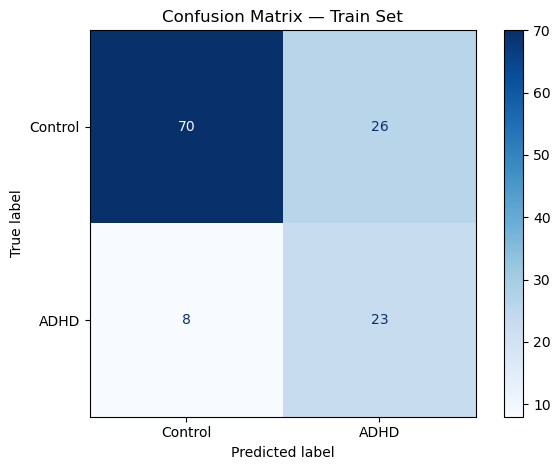

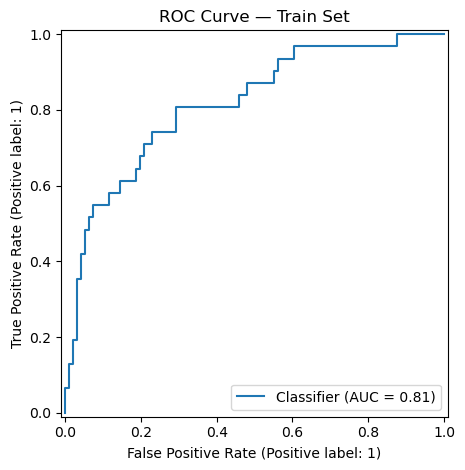

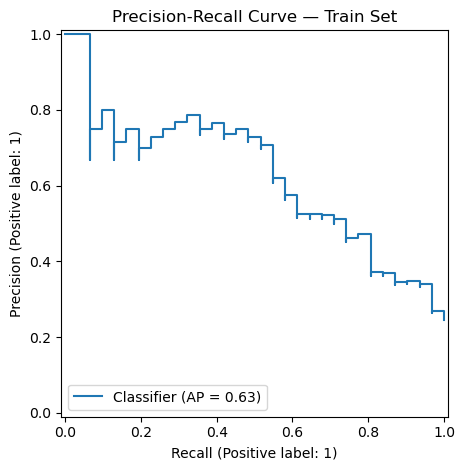


📊 Cross-Validated Scores (mean across folds):
fit_time: 0.2740
score_time: 0.0457
test_accuracy: 0.6046
train_accuracy: 0.7256
test_precision: 0.3270
train_precision: 0.4673
test_recall: 0.5607
train_recall: 0.7922
test_f1: 0.4079
train_f1: 0.5869
test_roc_auc: 0.6213
train_roc_auc: 0.8250

📘 Classification Report (Test):
              precision    recall  f1-score   support

     Control       0.83      0.79      0.81        24
        ADHD       0.44      0.50      0.47         8

    accuracy                           0.72        32
   macro avg       0.64      0.65      0.64        32
weighted avg       0.73      0.72      0.72        32

ROC AUC (Test): 0.7135416666666666


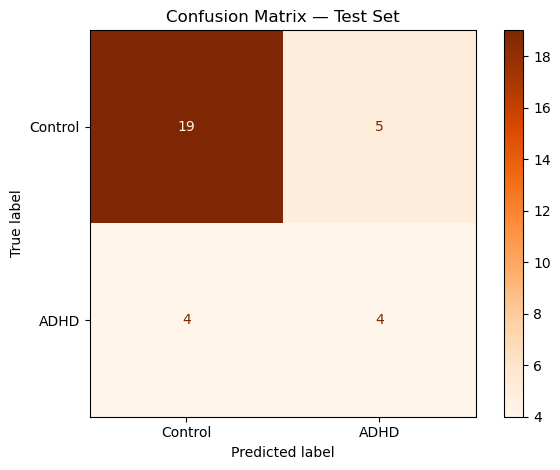

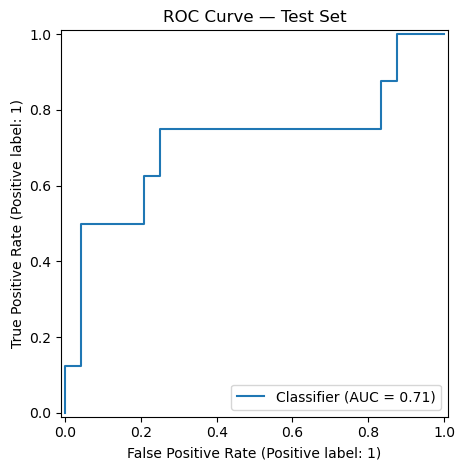

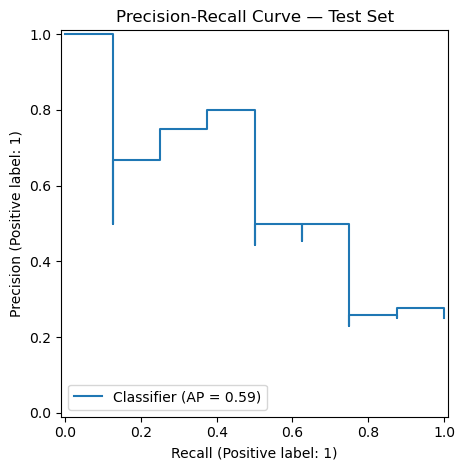

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, roc_auc_score, ConfusionMatrixDisplay,
                             RocCurveDisplay, PrecisionRecallDisplay)
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import RepeatedStratifiedKFold

# === Load and prepare data ===
df = pd.read_csv('Combined_4Condition_Cleaned.csv')
target_col = 'Label'
X = df.drop(columns=['Subject_ID', target_col])
y = df[target_col]

# === Train/test split ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# === Repeated Stratified K-Fold Cross-validation ===
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)

# === Pipeline with RandomUnderSampler and Logistic Regression ===
pipeline = Pipeline([
    
    ('feature_select', SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42),
                                       threshold=-np.inf, max_features=16)),
    
    ('under', RandomUnderSampler(random_state=None)),
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(penalty='elasticnet', solver='saga', max_iter=10000))
])

# === Parameter grid ===
param_grid = {
    'logreg__C': np.logspace(-3, 1, 5),
    'logreg__l1_ratio': np.linspace(0, 1, 6),
    'logreg__class_weight': [None]
}

# === Grid Search ===
grid_p = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring={
        'accuracy': 'accuracy',
        'precision': 'precision',
        'recall': 'recall',
        'f1': 'f1',
        'roc_auc': 'roc_auc'
    },
    refit='accuracy',  # <=== Focus on minority class detection
    cv=cv,
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

# === Fit model ===
grid_p.fit(X_train, y_train)
print("✅ Best Params:", grid_p.best_params_)

# === Train evaluation ===
y_train_pred = grid_p.predict(X_train)
y_train_proba = grid_p.predict_proba(X_train)[:, 1]

print("📘 Classification Report (Train):")
print(classification_report(y_train, y_train_pred, target_names=['Control', 'ADHD']))
print("ROC AUC (Train):", roc_auc_score(y_train, y_train_proba))

ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, display_labels=['Control', 'ADHD'], cmap='Blues')
plt.title("Confusion Matrix — Train Set")
plt.tight_layout()
plt.show()

RocCurveDisplay.from_predictions(y_train, y_train_proba)
plt.title("ROC Curve — Train Set")
plt.tight_layout()
plt.show()

PrecisionRecallDisplay.from_predictions(y_train, y_train_proba)
plt.title("Precision-Recall Curve — Train Set")
plt.tight_layout()
plt.show()

# === Cross-Validated Scores ===
cv_scores = cross_validate(
    grid_p.best_estimator_,
    X, y,
    scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
    cv=cv,
    return_train_score=True
)

print("\n📊 Cross-Validated Scores (mean across folds):")
for k, v in cv_scores.items():
    print(f"{k}: {np.mean(v):.4f}")

# === Test evaluation ===
y_test_pred = grid_p.predict(X_test)
y_test_proba = grid_p.predict_proba(X_test)[:, 1]

print("\n📘 Classification Report (Test):")
print(classification_report(y_test, y_test_pred, target_names=['Control', 'ADHD']))
print("ROC AUC (Test):", roc_auc_score(y_test, y_test_proba))

ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, display_labels=['Control', 'ADHD'], cmap='Oranges')
plt.title("Confusion Matrix — Test Set")
plt.tight_layout()
plt.show()

RocCurveDisplay.from_predictions(y_test, y_test_proba)
plt.title("ROC Curve — Test Set")
plt.tight_layout()
plt.show()

PrecisionRecallDisplay.from_predictions(y_test, y_test_proba)
plt.title("Precision-Recall Curve — Test Set")
plt.tight_layout()
plt.show()


# SMOTEENN

Fitting 50 folds for each of 60 candidates, totalling 3000 fits
✅ Best Params: {'logreg__C': 0.1, 'logreg__class_weight': None, 'logreg__l1_ratio': 0.2}
📘 Classification Report (Train):
              precision    recall  f1-score   support

     Control       0.92      0.57      0.71        96
        ADHD       0.39      0.84      0.53        31

    accuracy                           0.64       127
   macro avg       0.65      0.71      0.62       127
weighted avg       0.79      0.64      0.66       127

ROC AUC (Train): 0.8111559139784946


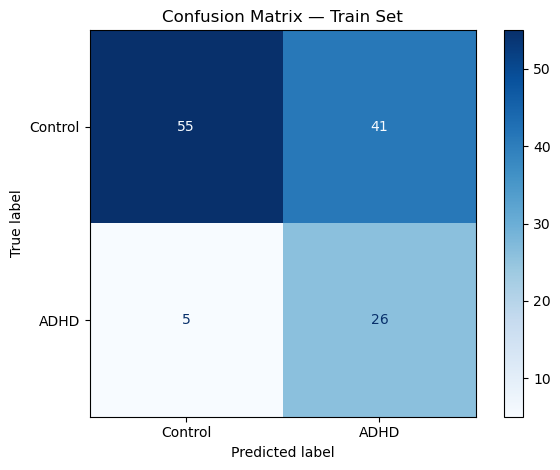

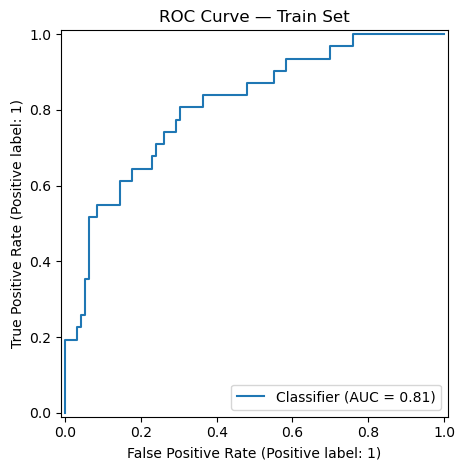

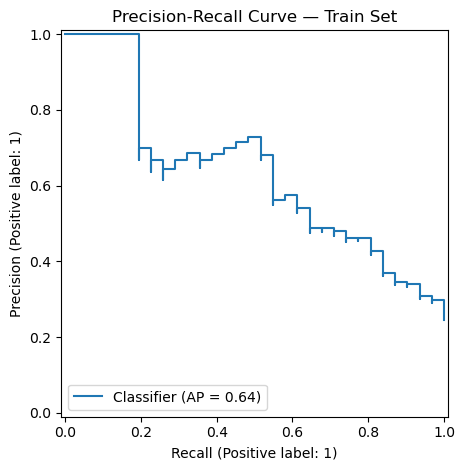


📊 Cross-Validated Scores (mean across folds):
fit_time: 0.2821
score_time: 0.0450
test_accuracy: 0.4964
train_accuracy: 0.6135
test_precision: 0.2974
train_precision: 0.3792
test_recall: 0.7183
train_recall: 0.8609
test_f1: 0.4105
train_f1: 0.5235
test_roc_auc: 0.5960
train_roc_auc: 0.7997

📘 Classification Report (Test):
              precision    recall  f1-score   support

     Control       0.92      0.50      0.65        24
        ADHD       0.37      0.88      0.52         8

    accuracy                           0.59        32
   macro avg       0.65      0.69      0.58        32
weighted avg       0.78      0.59      0.62        32

ROC AUC (Test): 0.765625


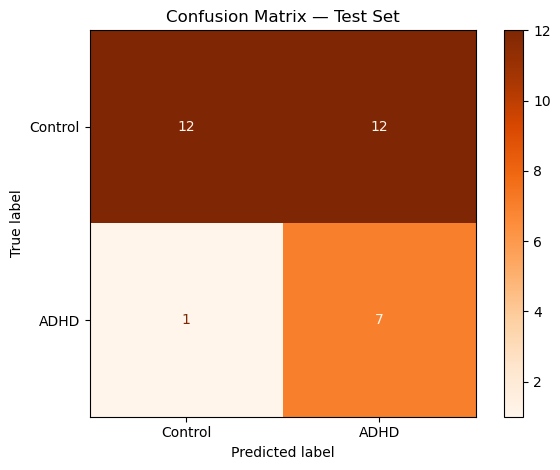

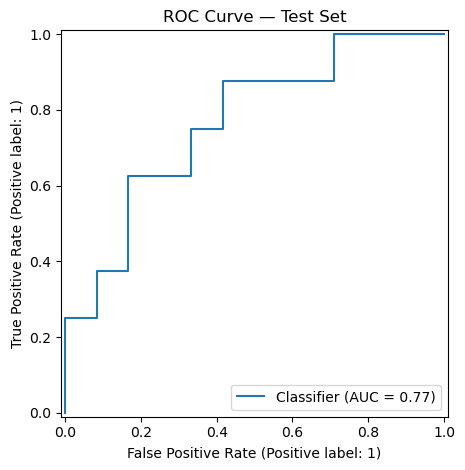

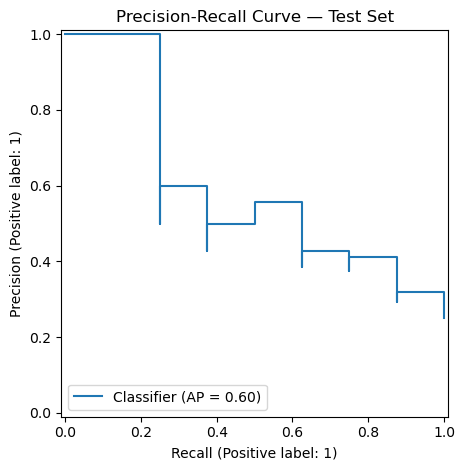

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, roc_auc_score, ConfusionMatrixDisplay,
                             RocCurveDisplay, PrecisionRecallDisplay)
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN

# === Load and prepare data ===
df = pd.read_csv('Combined_4Condition_Cleaned.csv')
target_col = 'Label'
X = df.drop(columns=['Subject_ID', target_col])
y = df[target_col]

# === Train/test split ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# === Repeated Stratified K-Fold Cross-validation ===
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=42)

# === Pipeline with SMOTE and Logistic Regression ===
pipeline = Pipeline([
    
    ('feature_select', SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42),
                                       threshold=-np.inf, max_features=16)),
    ('scaler', StandardScaler()),
    ('smoteenn', SMOTEENN(random_state=42)),
    ('logreg', LogisticRegression(penalty='elasticnet', solver='saga', max_iter=10000))
])

# === Parameter grid ===
param_grid = {
    'logreg__C': np.logspace(-3, 1, 5),
    'logreg__l1_ratio': np.linspace(0, 1, 6),
    'logreg__class_weight': [None, 'balanced']
}

# === Grid Search ===
grid_p = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring={
        'accuracy': 'accuracy',
        'precision': 'precision',
        'recall': 'recall',
        'f1': 'f1',
        'roc_auc': 'roc_auc'
    },
    refit='f1',  # <=== Focus on minority class detection
    cv=cv,
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

# === Fit model ===
grid_p.fit(X_train, y_train)
print("✅ Best Params:", grid_p.best_params_)

# === Train evaluation ===
y_train_pred = grid_p.predict(X_train)
y_train_proba = grid_p.predict_proba(X_train)[:, 1]

print("📘 Classification Report (Train):")
print(classification_report(y_train, y_train_pred, target_names=['Control', 'ADHD']))
print("ROC AUC (Train):", roc_auc_score(y_train, y_train_proba))

ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, display_labels=['Control', 'ADHD'], cmap='Blues')
plt.title("Confusion Matrix — Train Set")
plt.tight_layout()
plt.show()

RocCurveDisplay.from_predictions(y_train, y_train_proba)
plt.title("ROC Curve — Train Set")
plt.tight_layout()
plt.show()

PrecisionRecallDisplay.from_predictions(y_train, y_train_proba)
plt.title("Precision-Recall Curve — Train Set")
plt.tight_layout()
plt.show()

# === Cross-Validated Scores ===
cv_scores = cross_validate(
    grid_p.best_estimator_,
    X_train, y_train,
    scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
    cv=cv,
    return_train_score=True
)

print("\n📊 Cross-Validated Scores (mean across folds):")
for k, v in cv_scores.items():
    print(f"{k}: {np.mean(v):.4f}")

# === Test evaluation ===
y_test_pred = grid_p.predict(X_test)
y_test_proba = grid_p.predict_proba(X_test)[:, 1]

print("\n📘 Classification Report (Test):")
print(classification_report(y_test, y_test_pred, target_names=['Control', 'ADHD']))
print("ROC AUC (Test):", roc_auc_score(y_test, y_test_proba))

ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, display_labels=['Control', 'ADHD'], cmap='Oranges')
plt.title("Confusion Matrix — Test Set")
plt.tight_layout()
plt.show()

RocCurveDisplay.from_predictions(y_test, y_test_proba)
plt.title("ROC Curve — Test Set")
plt.tight_layout()
plt.show()

PrecisionRecallDisplay.from_predictions(y_test, y_test_proba)
plt.title("Precision-Recall Curve — Test Set")
plt.tight_layout()
plt.show()


# BalancBagging Classifier

Fitting 10 folds for each of 35 candidates, totalling 350 fits
✅ Best Params: {'lr__estimator__C': 0.1, 'lr__estimator__class_weight': None, 'lr__estimator__l1_ratio': 0.3}
📘 Classification Report (Train):
              precision    recall  f1-score   support

     Control       0.91      0.71      0.80        96
        ADHD       0.46      0.77      0.58        31

    accuracy                           0.72       127
   macro avg       0.68      0.74      0.69       127
weighted avg       0.80      0.72      0.74       127

ROC AUC (Train): 0.8306451612903226


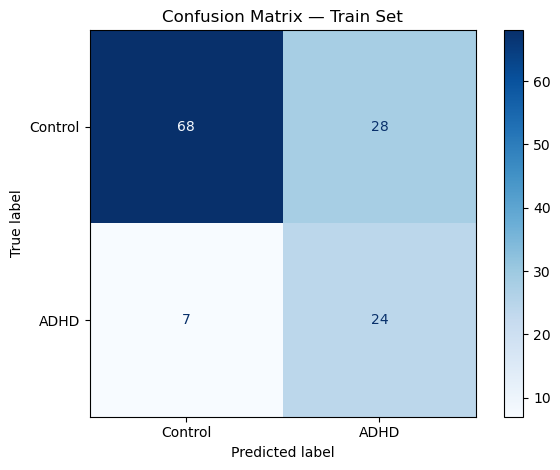

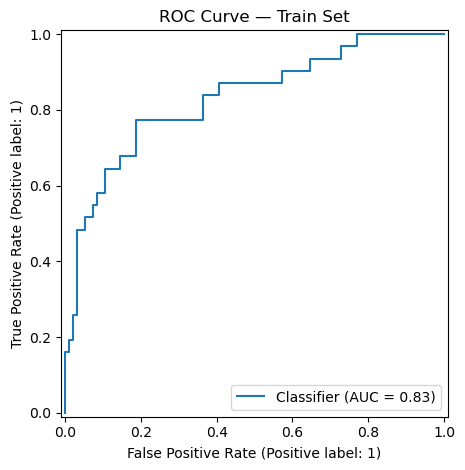

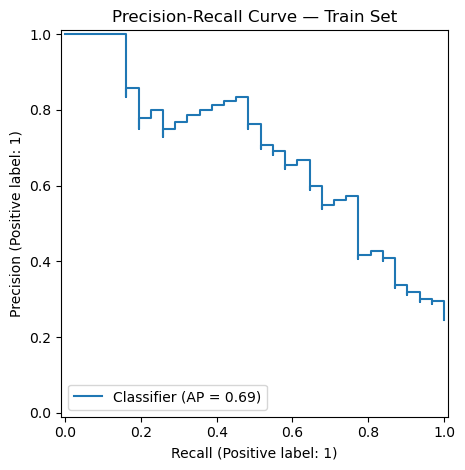


📊 Cross-Validated Scores:
fit_time: 0.4496
score_time: 0.1443
test_accuracy: 0.6292
train_accuracy: 0.7484
test_precision_macro: 0.5789
train_precision_macro: 0.7029
test_recall_macro: 0.5917
train_recall_macro: 0.7602
test_f1_macro: 0.5634
train_f1_macro: 0.7100
test_roc_auc: 0.6965
train_roc_auc: 0.8370

📘 Classification Report (Test):
              precision    recall  f1-score   support

     Control       0.86      0.79      0.83        24
        ADHD       0.50      0.62      0.56         8

    accuracy                           0.75        32
   macro avg       0.68      0.71      0.69        32
weighted avg       0.77      0.75      0.76        32

ROC AUC (Test): 0.796875


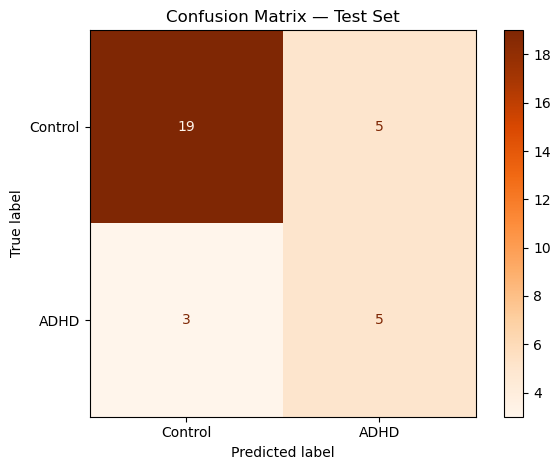

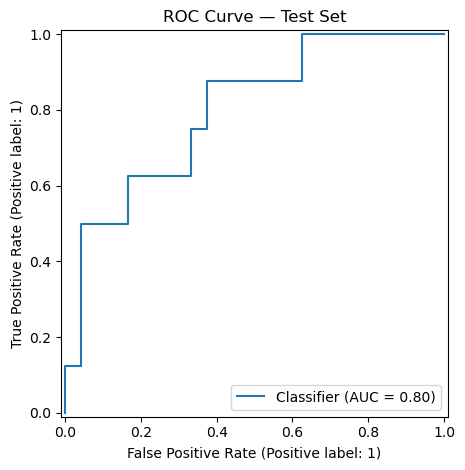

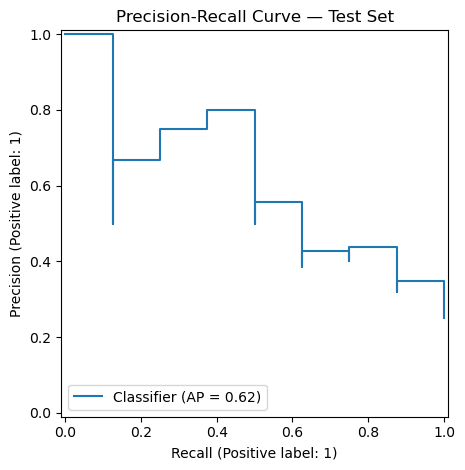

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix, ConfusionMatrixDisplay,
                             roc_auc_score, RocCurveDisplay, PrecisionRecallDisplay)
from imblearn.ensemble import BalancedBaggingClassifier


from sklearn.model_selection import train_test_split

# === Set the shared path and load data set ===
base_path = r'G:\csv_outputs'
df_combined = pd.read_csv(f"{base_path}\\Combined_4Condition_Cleaned.csv")

# === STEP 1: Prepare features and labels ===
X = df_combined.drop(columns=['Subject_ID', 'Label'])
y = df_combined['Label']
subject_ids = df_combined['Subject_ID']

# === STEP 2: Train-test split (keep test untouched)
X_train, X_test, y_train, y_test, ids_train, ids_test = train_test_split(
    X, y, subject_ids, test_size=0.2, stratify=y, random_state=42
)

# === Stratified K-Fold ===
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# === Feature Selector with Random Forest (on raw features) ===
rf_selector = SelectFromModel(
    estimator=RandomForestClassifier(n_estimators=100, random_state=42),
    threshold=-np.inf,
    max_features=20
)

# === ElasticNet Logistic Regression ===

elastic_base_model = LogisticRegression(
    penalty='elasticnet',
    solver='saga',
    max_iter=10000
)

# ✅ Wrap it in BaggingClassifier
elastic_model = BalancedBaggingClassifier(
    estimator=elastic_base_model,
    n_estimators=100,
    random_state=42,
    n_jobs=-1,
    sampling_strategy='auto',  # Optional: Controls undersampling
    replacement=False,
    bootstrap=True
)

# === Pipeline: Raw -> RF selector -> Scaler -> LogisticRegression ===
pipeline = Pipeline([
    ('feature_select', rf_selector),
    ('scaler', StandardScaler()),
    ('lr', elastic_model)
])

# === Param Grid ===
param_grid = {
    'lr__estimator__C': np.logspace(-3, 1, 5),
    'lr__estimator__l1_ratio': [0, 0.1,  0.3, 0.5, 0.7,  0.9, 1],
    'lr__estimator__class_weight': [None]
}


# === Grid SearchCV ===
grid_p = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring={
        'accuracy': 'accuracy',
        'precision_macro': 'precision_macro',
        'recall_macro': 'recall_macro',
        'f1_macro': 'f1_macro',
        'roc_auc': 'roc_auc'
    },
    refit='f1_macro',
    cv=cv,
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

# === Fit Model ===
grid_p.fit(X_train, y_train)
print("✅ Best Params:", grid_p.best_params_)

# === Train Predictions ===
y_train_pred = grid_p.predict(X_train)
y_train_proba = grid_p.predict_proba(X_train)[:, 1]

# === Evaluation Metrics (Train) ===
print("📘 Classification Report (Train):")
print(classification_report(y_train, y_train_pred, target_names=['Control', 'ADHD']))
print("ROC AUC (Train):", roc_auc_score(y_train, y_train_proba))

# === Confusion Matrix (Train) ===
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, display_labels=['Control', 'ADHD'], cmap='Blues')
plt.title("Confusion Matrix — Train Set")
plt.tight_layout()
plt.show()

# === ROC Curve (Train) ===
RocCurveDisplay.from_predictions(y_train, y_train_proba)
plt.title("ROC Curve — Train Set")
plt.tight_layout()
plt.show()

# === Precision-Recall Curve (Train) ===
PrecisionRecallDisplay.from_predictions(y_train, y_train_proba)
plt.title("Precision-Recall Curve — Train Set")
plt.tight_layout()
plt.show()

# === Cross-Validated Scores ===
cv_scores = cross_validate(
    grid_p.best_estimator_,
    X, y,
    scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'roc_auc'],
    cv=cv,
    return_train_score=True
)

print("\n📊 Cross-Validated Scores:")
for k, v in cv_scores.items():
    print(f"{k}: {np.mean(v):.4f}")

# === TEST PREDICTIONS AND EVALUATION ===
y_test_pred = grid_p.predict(X_test)
y_test_proba = grid_p.predict_proba(X_test)[:, 1]

print("\n📘 Classification Report (Test):")
print(classification_report(y_test, y_test_pred, target_names=['Control', 'ADHD']))
print("ROC AUC (Test):", roc_auc_score(y_test, y_test_proba))

# === Confusion Matrix (Test) ===
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, display_labels=['Control', 'ADHD'], cmap='Oranges')
plt.title("Confusion Matrix — Test Set")
plt.tight_layout()
plt.show()

# === ROC Curve (Test) ===
RocCurveDisplay.from_predictions(y_test, y_test_proba)
plt.title("ROC Curve — Test Set")
plt.tight_layout()
plt.show()

# === Precision-Recall Curve (Test) ===
PrecisionRecallDisplay.from_predictions(y_test, y_test_proba)
plt.title("Precision-Recall Curve — Test Set")
plt.tight_layout()
plt.show()
